In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.19.0


In [ ]:
train_dir = Path('/content/drive/MyDrive/DL project/train')
train_filepaths= list(train_dir.glob(r'**/*.jpg'))


In [ ]:
test_dir = Path('/content/drive/MyDrive/DL project/test')
test_filepaths= list(test_dir.glob(r'**/*.jpg'))


In [ ]:
val_dir = Path('/content/drive/MyDrive/DL project/validation')
val_filepaths= list(val_dir.glob(r'**/*.jpg'))


In [ ]:
def image_processing(filepaths):
    # Extract labels from file paths
    labels = [str(filepaths[i]).split("/")[-2] for i in range(len(filepaths))]

    # Create DataFrame with 'filepath' and 'label' columns
    df = pd.DataFrame({
        'filepath': [str(fp) for fp in filepaths],
        'label': labels
    })

    # Shuffle the DataFrame
    df = df.sample(frac=1).reset_index(drop=True)

    return df


In [ ]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [ ]:
print('---Training Set--\n')
print(f'Number of pictures:{train_df.shape[0]}\n')
print(f"Number of different_labels:{len(train_df.label.unique())}\n")
print(f'Labels:{train_df.label.unique()}')

---Training Set--

Number of pictures:2781

Number of different_labels:36

Labels:['cauliflower' 'peas' 'pomegranate' 'soy beans' 'banana' 'lemon' 'turnip'
 'beetroot' 'sweetcorn' 'grapes' 'cabbage' 'ginger' 'pineapple' 'orange'
 'tomato' 'garlic' 'capsicum' 'apple' 'potato' 'jalepeno' 'chilli pepper'
 'pear' 'eggplant' 'corn' 'raddish' 'bell pepper' 'cucumber' 'sweetpotato'
 'paprika' 'kiwi' 'onion' 'spinach' 'watermelon' 'lettuce' 'carrot'
 'mango']


In [ ]:
train_df.head(5)

,filepath,label
0,/content/drive/MyDrive/DL project/train/caulif...,cauliflower
1,/content/drive/MyDrive/DL project/train/peas/I...,peas
2,/content/drive/MyDrive/DL project/train/pomegr...,pomegranate
3,/content/drive/MyDrive/DL project/train/soy be...,soy beans
4,/content/drive/MyDrive/DL project/train/banana...,banana


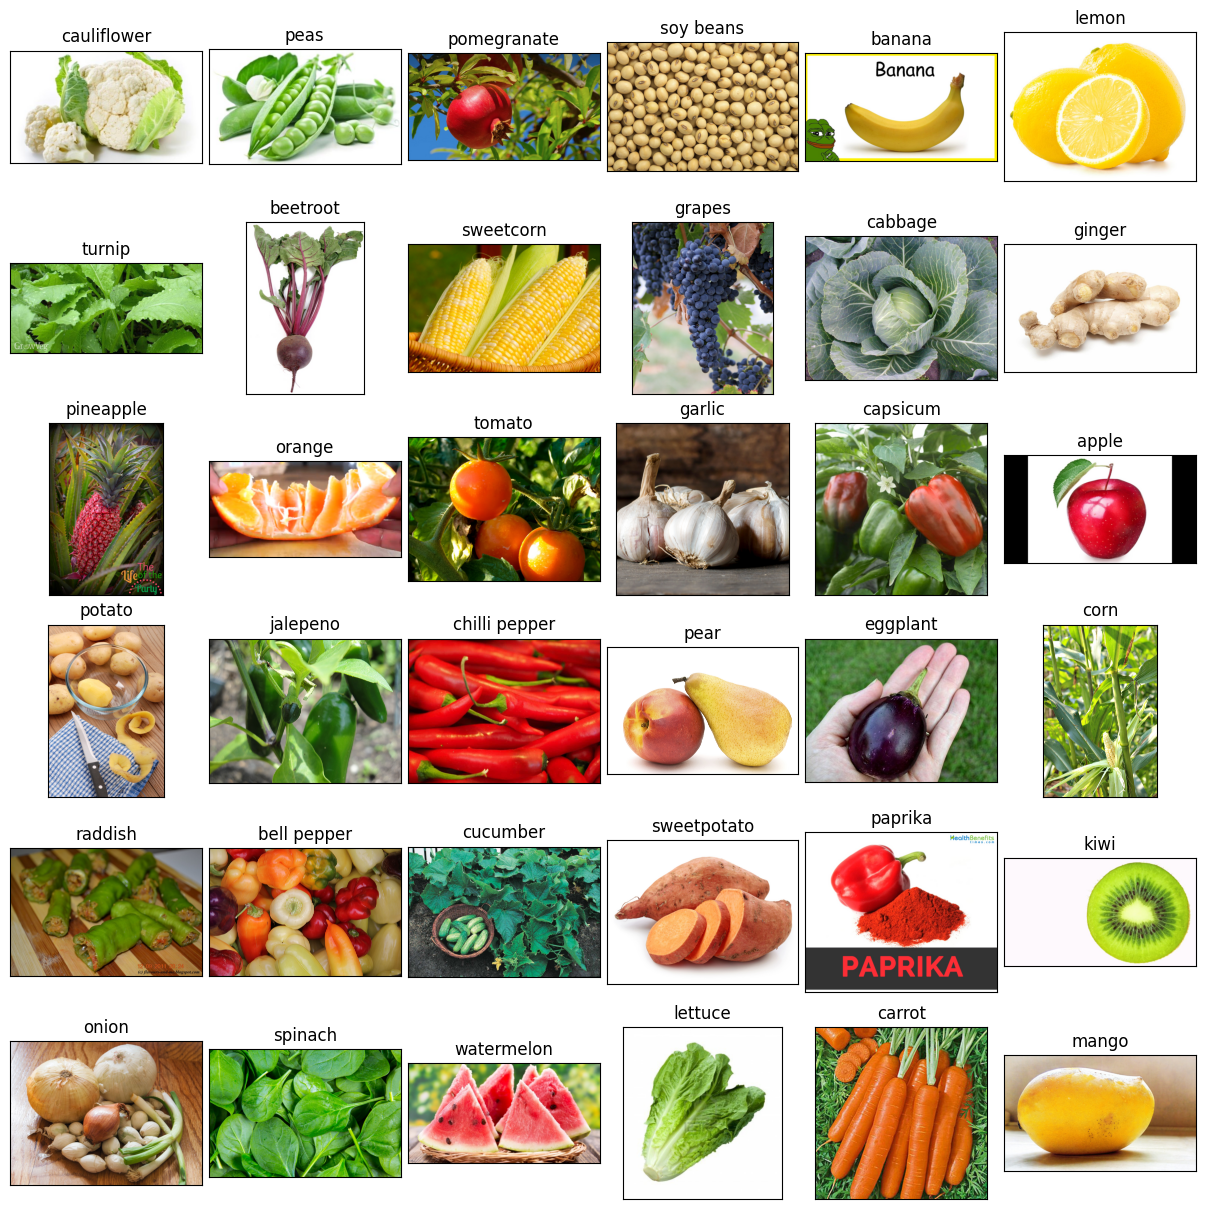

In [ ]:
# Remove duplicate labels
df_unique = train_df.copy().drop_duplicates(subset=['label']).reset_index(drop=True)

# Create subplots
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(12,12),
                         subplot_kw={'xticks':[], 'yticks':[]})
axes = axes.flatten()

# Plot images and labels
for i, ax in enumerate(axes):
    if i < len(df_unique):
        img = plt.imread(df_unique['filepath'][i])
        ax.imshow(img)
        ax.set_title(df_unique['label'][i], fontsize=12)
    else:
        ax.axis('off')  # Hide unused subplots

plt.tight_layout(pad=0.5)
plt.show()


In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',     # Correct column name
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)


Found 2781 validated image filenames belonging to 36 classes.


In [ ]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

Found 334 validated image filenames belonging to 36 classes.


In [ ]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 334 validated image filenames belonging to 36 classes.


In [ ]:
pretrained_model= tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
)
pretrained_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
inputs= pretrained_model.input

x=tf.keras.layers.Dense(128,activation='relu')(pretrained_model.output)
x=tf.keras.layers.Dense(128,activation='relu')(x)

outputs= tf.keras.layers.Dense(36,activation='softmax')(x)

model=tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer ='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data = val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True

        )
    ]
)



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 1514s 17s/step - accuracy: 0.3350 - loss: 2.5719 - val_accuracy: 0.8383 - val_loss: 0.5027
Epoch 2/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8243 - loss: 0.5834 - val_accuracy: 0.9072 - val_loss: 0.3424
Epoch 3/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8907 - loss: 0.3450 - val_accuracy: 0.9281 - val_loss: 0.2501
Epoch 4/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 80s 917ms/step - accuracy: 0.9483 - loss: 0.2064 - val_accuracy: 0.9461 - val_loss: 0.2228
Epoch 5/5
87/87 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9590 - loss: 0.1375 - val_accuracy: 0.9461 - val_loss: 0.1944


In [ ]:
#predict the label of the test_images
pred=model.predict(test_images)
pred=np.argmax(pred,axis=1)
#map the label
labels=(train_images.class_indices)
labels=dict((v,k) for k,v in labels.items())
pred1=[labels[k] for k in pred]
pred1

11/11 ━━━━━━━━━━━━━━━━━━━━ 126s 12s/step


['paprika',
 'sweetpotato',
 'pear',
 'pineapple',
 'peas',
 'cauliflower',
 'garlic',
 'orange',
 'banana',
 'peas',
 'tomato',
 'watermelon',
 'banana',
 'pomegranate',
 'lettuce',
 'kiwi',
 'lemon',
 'jalepeno',
 'chilli pepper',
 'jalepeno',
 'beetroot',
 'lettuce',
 'garlic',
 'spinach',
 'capsicum',
 'capsicum',
 'orange',
 'jalepeno',
 'apple',
 'apple',
 'paprika',
 'paprika',
 'cucumber',
 'pomegranate',
 'chilli pepper',
 'ginger',
 'cabbage',
 'pear',
 'onion',
 'potato',
 'watermelon',
 'pineapple',
 'peas',
 'potato',
 'bell pepper',
 'turnip',
 'kiwi',
 'bell pepper',
 'carrot',
 'garlic',
 'sweetcorn',
 'pineapple',
 'watermelon',
 'lettuce',
 'raddish',
 'spinach',
 'eggplant',
 'kiwi',
 'soy beans',
 'raddish',
 'garlic',
 'cauliflower',
 'pear',
 'jalepeno',
 'ginger',
 'peas',
 'kiwi',
 'mango',
 'sweetpotato',
 'tomato',
 'sweetpotato',
 'sweetpotato',
 'mango',
 'peas',
 'watermelon',
 'chilli pepper',
 'spinach',
 'tomato',
 'mango',
 'onion',
 'tomato',
 'lettuce

In [ ]:
def output(location):
  img=load_img(location,target_size=(224,224,3))
  img=img_to_array(img)
  img=img/255
  img=np.expand_dims(img,[0])
  answer=model.predict(img)
  y_class = answer.argmax(axis=-1)
  y = " ".join(str(x) for x in y_class)
  y = int(y)
  res = labels[y]
  return res

In [ ]:
img = output('/content/drive/MyDrive/DL project/test/carrot/Image_1.jpg')
img

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


'carrot'

In [ ]:
model.save('FV.h5')